In [20]:
import numpy as np
import numpy.ma as ma

import time

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

In [21]:
%load_ext autoreload
%autoreload 1
%aimport sigproc
%aimport config_svm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
%aimport svm

In [23]:
change_printopt = config_svm.printoptions

In [24]:
pic_dir = config_svm.pic_dir

In [25]:
import sys
Eps =  config_svm.Eps #sys.float_info.epsilon

# 3. Эксперименты на реальных данных

Создаем многомерный массив, размерность (количетво нужных символов (английские буквы)= 26x2,
                                         количество респондентов=60,
                                         количество повторений=2,
                                         вектор измерений (x, y) = 2,
                                         максимальное количество измерений = количество измерений) //надо посчитать

In [26]:
import re
from os import walk

r_strokenum = re.compile('\s+NUMSTROKES (\d)')
r_pntnum = re.compile('\s+POINTS (\d+) #*')
r_word = re.compile('WORD ([a-zA-Z]) (trn|tst)_(UJI|UPV)_W(\d\d)-(01|02)', re.A)
strokenum = 0
num = 0
cnt = 0
max_d = 0

file_name = 'data/uji-penchars/ver2/ujipenchars2.txt'
data_file = open(file_name)
text_data = data_file.read().splitlines()
it_text = iter(text_data)

for line in it_text:
    if r_word.match(line):
        letter = r_word.match(line).group(1)
        num = 0
        line = next(it_text)
        strokenum = int(r_strokenum.match(line).group(1))
        cnt += 1
        while(strokenum):
            line = next(it_text)
            num += int(r_pntnum.match(line).group(1))
            strokenum -= 1 
        if max_d < num:
            max_d = num
            #print(letter, max_d) - Напечатать буквы макимизирующие вырпжение

In [27]:
keys = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
 "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z",
 "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M",
 "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
values = list(range(len(keys)))
lexicon = dict(zip(keys, values))
anti_lexicon = dict(zip(values, keys))
frame_size = np.array([13.6, 20.4]) 
UJI_ratio, UPV_ratio = 100, 152

print("Больше всего точек буквы = ", max_d)
masked_fill_value = 1.e-20
real_data = masked_fill_value*np.ones((len(keys), 60, 2, 2, max_d), dtype=np.float64)

Больше всего точек буквы =  392


In [28]:
print("Mbytes in data stored as masked arrays with length {0:d}: {1:.5f} Mb".format(max_d, real_data.nbytes / 2**(20)))

Mbytes in data stored as masked arrays with length 392: 37.32422 Mb


In [29]:
r_word = re.compile('WORD ([a-zA-Z]) (trn|tst)_(UJI|UPV)_W(\d\d)-(01|02)', re.A)
r_pntnum = re.compile('\s+POINTS (\d+) #((\s+-?\d+)*)')

it_text = iter(text_data)
for line in it_text:
    if r_word.match(line):
        letter, UnivDivider, writer, repet = r_word.match(line).group(1, 3, 4, 5)
        line = next(it_text)
        strokenum = int(r_strokenum.match(line).group(1))
        stroke_offset = 0
        while(strokenum):
            line = next(it_text)
            pntnum_m = r_pntnum.match(line)
            pnts_num = int(pntnum_m.group(1))
            #print(pnts_num)
            #print(pntnum_m.group(2)[1:].split(sep=' '))
            pnts = np.array([int(pnt_xy) for pnt_xy in pntnum_m.group(2)[1:].split(sep=' ')])
            divider = 1
###can change divider parametr
            if UnivDivider == 'UPV':
                divider = UPV_ratio/UJI_ratio 
            #print(lexicon[letter], int(writer) - 1, int(repet) - 1)
            #try:
            real_data[lexicon[letter], int(writer) - 1, int(repet) - 1, 0,
                      stroke_offset:stroke_offset + pnts_num] = pnts[::2]/divider # x coords
            real_data[lexicon[letter], int(writer) - 1, int(repet) - 1, 1,
                      stroke_offset:stroke_offset + pnts_num] = pnts[1::2]/divider # y coords
            #except ValueError:
            #    print(pnts.shape)
            stroke_offset += pnts_num
            strokenum -= 1

In [30]:
real_data = ma.masked_values(real_data, value=masked_fill_value)

In [31]:
with config_svm.printoptions(suppress=True):
    print(real_data)

[[[[[557.0 550.0 550.0 ..., -- -- --]
    [844.0 803.0 803.0 ..., -- -- --]]

   [[614.0 614.0 614.0 ..., -- -- --]
    [743.0 743.0 743.0 ..., -- -- --]]]


  [[[544.0 544.0 578.0 ..., -- -- --]
    [1017.0 1017.0 969.0 ..., -- -- --]]

   [[645.0 649.0 649.0 ..., -- -- --]
    [1031.0 982.0 982.0 ..., -- -- --]]]


  [[[433.0 433.0 433.0 ..., -- -- --]
    [497.0 497.0 497.0 ..., -- -- --]]

   [[487.0 487.0 487.0 ..., -- -- --]
    [785.0 785.0 785.0 ..., -- -- --]]]


  ..., 
  [[[723.6842105263158 723.6842105263158 723.6842105263158 ..., -- -- --]
    [831.578947368421 831.578947368421 831.578947368421 ..., -- -- --]]

   [[633.5526315789474 633.5526315789474 633.5526315789474 ..., -- -- --]
    [882.2368421052631 882.2368421052631 882.2368421052631 ..., -- -- --]]]


  [[[590.7894736842105 590.7894736842105 590.7894736842105 ..., -- -- --]
    [821.7105263157895 821.7105263157895 821.7105263157895 ..., -- -- --]]

   [[665.7894736842105 665.7894736842105 665.7894736842105 ..., --

In [32]:
def vis_letters(letter_index, real_data,frame=frame_size, ratio=UJI_ratio, vert_lines=np.array([7.5,12.7]), verbose=True):
    points_xy = real_data[letter_index].compressed().reshape(2, -1)
    fig = plt.figure(figsize=frame/2)
    ax = fig.gca()
    ax.plot(points_xy[0], points_xy[1], 'k-', linewidth=0.5)
    ax.scatter(points_xy[0, 1:-1], points_xy[1, 1:-1], c='b', marker='o', s=30)
    ax.scatter(points_xy[0, 0], points_xy[1, 0], c=(0, 0.95, 0), marker='o', s=40) #start
    ax.scatter(points_xy[0, -1], points_xy[1, -1], c=(0.95, 0, 0), marker='o', s=40) #end
    xlim = [0.0, frame[0]*ratio]
    ylim = [0.0, frame[1]*ratio]
    ax.xaxis.tick_top()
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.plot(xlim, vert_lines[[0, 0]]*ratio, 'k', lw=1)
    ax.plot(ylim, vert_lines[[1, 1]]*ratio, 'k', lw=1)
    ax.set_xticks(np.arange(*(xlim + [100])))
    ax.set_yticks(np.arange(*(ylim + [100])))
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=10)
    if verbose:
        ax.set_title("Буква '{0:s}'\tреспондент {1:d}\tпопытка {2:d}".format(
                anti_lexicon[letter_index[0]], letter_index[1] + 1, letter_index[2] + 1),fontsize=20, y=1.03)
    ax.invert_yaxis()
    ax.grid()     

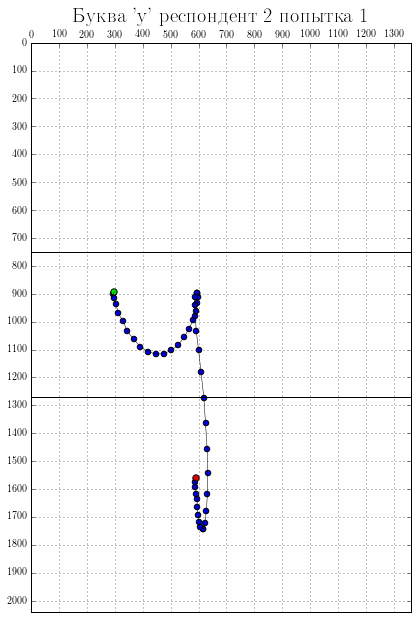

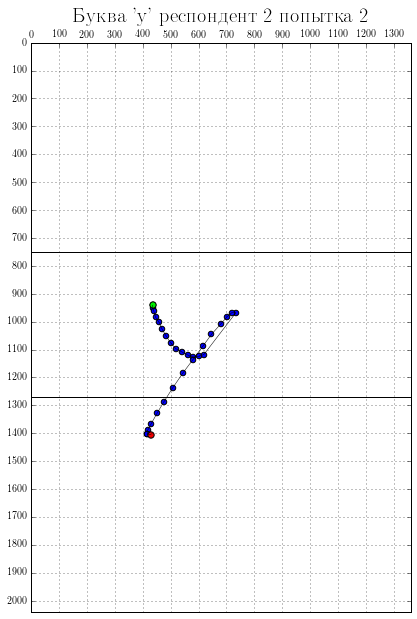

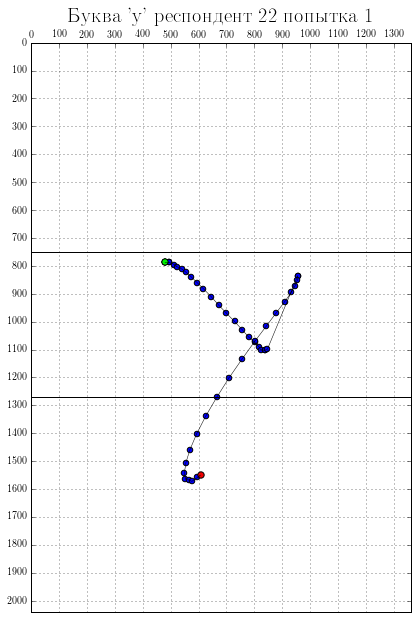

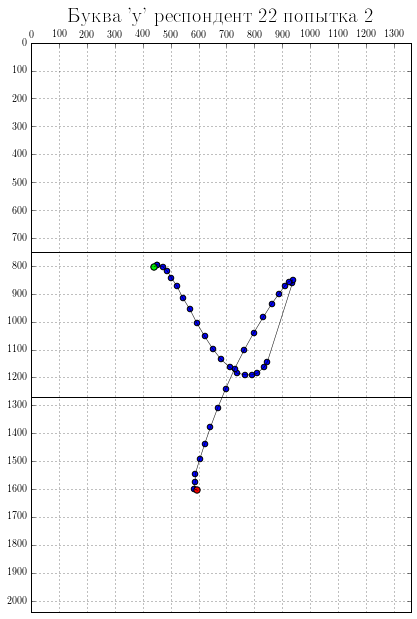

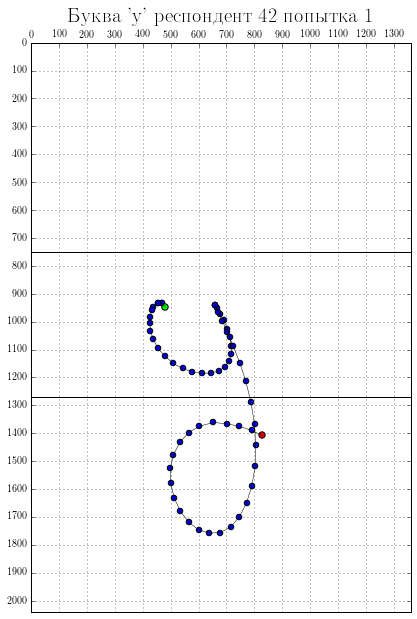

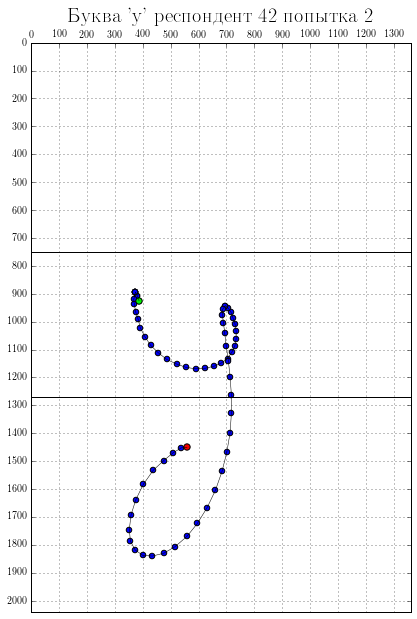

In [34]:
for writer in range(1, 60, 20):
    for repet in range(2):
        vis_letters((lexicon['y'], writer, repet), real_data)

## Making DTW preprocessing

In [35]:
def test(real_data, index_list):
    for ind in index_list:
        a = real_data[ind[0]].compressed().reshape(2, -1).T
        b = real_data[ind[1]].compressed().reshape(2, -1).T
        dist, D = sigproc.dtw(a, b, do_path=False)
        print("Буква '{0:s}'\tреспондент {1:d}\tпопытка 0 и 1: \t{2:.3f}".format(
                anti_lexicon[ind[0][0]], ind[0][1] + 1, dist))

In [36]:
index_list = [[(lexicon['y'], wr-1, 0), (lexicon['y'], wr-1, 1)] for wr in [2, 22,32]]
test(real_data, index_list)

Буква 'y'	респондент 2	попытка 0 и 1: 	8246.265
Буква 'y'	респондент 22	попытка 0 и 1: 	2660.133
Буква 'y'	респондент 32	попытка 0 и 1: 	3095.280


In [37]:
X = real_data[[lexicon['f'], lexicon['e']], :11, 0].reshape(-1, 2, max_d)
y = np.ones((X.shape[0],1))
y[X.shape[0]/2:] *= -1

In [51]:
SmSVM_feres_fe = svm.smooth_qp_primal_real_solver(X, y, np.array([0, 0, 0]), alpha=0, verbose=True)

Time elapsed [DTW]:  9.947141408920288
Time elapsed [Cone QP preparation]:  0.00018930435180664062
     pcost       dcost       gap    pres   dres
 0: -2.2000e-01  2.1995e+00  7e+01  2e+00  4e+05
 1:  1.7967e+00 -4.4330e-01  3e+00  2e-02  5e+03
 2:  1.5972e-01 -2.3132e-02  2e-01  2e-03  4e+02
 3:  1.0781e-01 -1.8162e-02  1e-01  1e-03  2e+02
 4:  4.3150e-02 -8.1977e-03  6e-02  4e-04  8e+01
 5:  1.9071e-02 -5.3817e-03  3e-02  1e-04  3e+01
 6:  4.7994e-03 -1.7682e-03  7e-03  3e-05  7e+00
 7:  3.0288e-04 -1.1365e-04  4e-04  2e-06  4e-01
 8:  5.4730e-06 -2.1669e-06  8e-06  3e-08  7e-03
 9:  5.4331e-07 -2.0771e-07  8e-07  2e-09  5e-04
10:  7.7647e-08 -2.0778e-08  1e-07  3e-15  1e-16
Optimal solution found.


[autoreload of svm failed: Traceback (most recent call last):
  File "/home/kvandy/anaconda3/lib/python3.4/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/home/kvandy/Documents/MMP/Krasotkina/kv_hw&Kursach/KV_hw/svm.py", line 185
    if True: pass
    ^
IndentationError: unexpected indent
]


In [52]:
SmSVM_feres_fe_al50 = svm.smooth_qp_primal_real_solver(X, y, np.array([0, 0, 0]), alpha=50, verbose=True)

Time elapsed [DTW]:  9.07717752456665
Time elapsed [Cone QP preparation]:  0.00018167495727539062
     pcost       dcost       gap    pres   dres
 0: -2.2000e-01  2.1995e+00  7e+01  2e+00  4e+05
 1:  1.7967e+00 -4.4330e-01  3e+00  2e-02  5e+03
 2:  1.5972e-01 -2.3131e-02  2e-01  2e-03  4e+02
 3:  1.0781e-01 -1.8162e-02  1e-01  1e-03  2e+02
 4:  4.3149e-02 -8.1975e-03  6e-02  4e-04  8e+01
 5:  1.9071e-02 -5.3815e-03  3e-02  1e-04  3e+01
 6:  4.7999e-03 -1.7684e-03  7e-03  3e-05  7e+00
 7:  3.0279e-04 -1.1361e-04  4e-04  2e-06  4e-01
 8:  5.6376e-06 -2.2316e-06  8e-06  3e-08  7e-03
 9:  5.8215e-07 -2.2109e-07  8e-07  2e-09  6e-04
10:  7.5568e-08 -2.0006e-08  1e-07  3e-15  1e-16
Optimal solution found.
